In [1]:
import numpy as np
np.seterr(divide='ignore')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import wlcave as wlcave #need to path correctly!
import matplotlib.cm as cm
import sys

#for data processing
import os
import operator
import xlrd

C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:174: RuntimeWarning: divide by zero encountered in exp2
  eps=exp2(ld(-112)),
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:53: RuntimeWarning: divide by zero encountered in log10
  self.precision = int(-log10(self.eps))
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:54: RuntimeWarning: divide by zero encountered in power
  self.resolution = float_to_float(float_conv(10) ** (-self.precision))
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:186: RuntimeWarning: divide by zero encountered in exp2
  epsneg_f80 = exp2(ld(-64))
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:187: RuntimeWarning: divide by zero encountered in exp2
  tiny_f80 = exp2(ld(-16382))
C:\Users\tmhab\anaconda3\lib\site-packages\numpy\core\getlimits.py:201: RuntimeWarning: divide by zero encountered in exp2
  eps=exp2(ld(-63)),
C:\Users\tmhab\anaconda3\lib\site-packages\nump

## Edited ABsolution

X_A-B = X_B-solvent != 0

X_A-solv = 0

In [2]:

phi_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/edited/5.9.2021_ABsolution_EDITED_rigid_kappa=20_24hrs/all_phis/"
rephist_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/edited/5.9.2021_ABsolution_EDITED_rigid_kappa=20_24hrs/finalrep.xlsx"
r_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_solution/edited/5.9.2021_ABsolution_EDITED_rigid_kappa=20_24hrs/all_rs/"

In [3]:
'''PREPROCESSING:
phi files- copy all into one folder
get chi values from repHistory (copy last exchange into new notepad, import into excel, save)
''' 
# load in phi files
os.chdir(phi_path)

phi_df_list = []
v_val_list = []
for file in os.listdir():
    file_path = f"{phi_path}\{file}"
    
    v_val = file_path[-2:]
    if v_val[0] == "v":
        v_val = v_val[1]
    v_val = float(v_val) # smallest v = smallest chi
        
    file_df = pd.read_csv(file_path, delimiter = "   |  -", names = ["Vol_A", "Vol_B"])
    
    phi_df_list.append([v_val, file_df])
    v_val_list.append(v_val)

phi_df_list = sorted(phi_df_list, key=operator.itemgetter(0))
v_val_list = sorted(v_val_list)

# load in rep history chis
wb = xlrd.open_workbook(rephist_path)
ws = wb.sheet_by_index(0)
chi_val_list = ws.col_values(4)[1:]

C:\Users\tmhab\anaconda3\lib\site-packages\ipykernel_launcher.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


### Degree of mixing <phi_A* phi_B>

In [4]:
phiA_B_list = []
for pair in phi_df_list:
    df_product = pair[1]["Vol_A"] * pair[1]["Vol_B"]
    phiA_B = df_product.mean()
    phiA_B_list.append(phiA_B)

phiA_B_list_full_range = phiA_B_list


Text(0.5, 0, 'X*v_m')

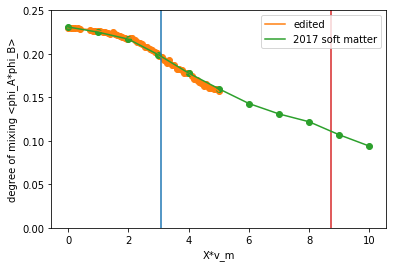

In [5]:
##### nondimensionalize x axis
chi_vals = np.array(chi_val_list)

# bead_volume = 0.1 # simulation units
# monomer_volume = 5 * bead_volume
# chi = E/v_bead-> chi * vm = E/v_bead * (5 * v_bead) (E in terms of kTs!!)

chi_v_m = chi_vals/0.2 

# my sim values
plt.scatter(chi_v_m, phiA_B_list, color = "tab:orange")
plt.plot(chi_v_m, phiA_B_list, label = "edited", color = "tab:orange")

plt.ylim((0, .25))
#plt.vlines(0.6562*5, 0, 0.25, color = "tab:blue")

# Estimating paper values
chi_v_m_paper = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
phiA_B_paper = [0.231, 0.225, 0.217, 0.199, 0.178, 0.16, 0.143, 0.131, 0.122, 0.107, 0.094] #imageJ
plt.scatter(chi_v_m_paper, phiA_B_paper, color = "tab:green")
plt.plot(chi_v_m_paper, phiA_B_paper, label = "2017 soft matter", color = "tab:green")

plt.vlines(3.1, 0, 0.25, color = "tab:blue")
plt.vlines(8.71, 0, 0.25, color = "tab:red")
plt.legend()
plt.ylabel("degree of mixing <phi_A*phi_B>")
plt.xlabel("X*v_m")
# significant deviation from paper. kappa val/ lack of parallel tempering (too big of X interval)

### Heat capacity

In [6]:
def slope(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    return m


slope_value=np.array([])
x = chi_v_m
y = phiA_B_list
for i in range(len(y)-1):
    i += 1
    v=slope(x[i], y[i], x[i-1], y[i-1])
    slope_value = np.append(slope_value, v)


Text(0.5, 1.0, 'edited, 24hrs')

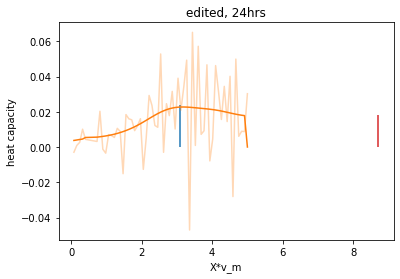

In [7]:
y_vals = slope_value*-1
x_vals = chi_v_m[1:]
sigma = 0.45 #paper- std dv = 0.45

smoothed_vals = np.zeros(len(y_vals)+1)
for i, x_val in enumerate(x_vals):
    kernel = np.exp(-(x_vals - x_val) ** 2 / (2 * sigma ** 2)) #gaussian centerd at each point
    kernel = kernel / sum(kernel) #normalize
    smoothed_vals[i] = sum(y_vals * kernel)
    
plt.plot(x_vals, smoothed_vals[1:], color= "tab:orange")

plt.vlines(3.1, -0.00, 0.024, color = "tab:blue") #post- kernel peaks, using image-J
plt.vlines(8.71, -0.00, 0.018, color = "tab:red")
plt.plot(chi_v_m[1:], slope_value*-1, label = "5.3.21", color = "tab:orange", alpha=0.3)
plt.ylabel("heat capacity")
plt.xlabel("X*v_m")
plt.title("edited, 24hrs")

### Radius of gyration

In [8]:
class Bead:
    '''
    '''
    def __init__(self, x, y, z, bead_type):
        self.x = x
        self.y = y
        self.z = z
        self.bead_type = bead_type
    
    def print_bead(self):
        print("x: ", self.x)
        print("Y: ", self.y)
        print("Z: ", self.z)
        
class Polymer:
    '''
    '''
    
    def __init__(self, bead_list):
        self.bead_list = []
        self.bead_list = bead_list
        bead_coor_array = np.zeros((len(bead_list), 3))
        bead_types = np.zeros(len(bead_list))
        for i, bead in enumerate(bead_list):
            bead_coor_array[i, 0] = bead.x
            bead_coor_array[i, 1] = bead.y
            bead_coor_array[i, 2] = bead.z
            bead_types[i] = bead.bead_type
        self.bead_coor_array = bead_coor_array
        self.bead_types = bead_types
    
    def poly_print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
   
    def find_center_of_mass(self): 
        '''
        Find the center of mass for a given polymer chain wrt to a specific bead type
        '''
        #print("IN COM METHOD")
        X_bead = self.bead_coor_array[:,0]#[self.bead_types==bead_num] 
        Y_bead = self.bead_coor_array[:,1]#[self.bead_types==bead_num]
        Z_bead = self.bead_coor_array[:,2]#[self.bead_types==bead_num]
        
        x_center = np.mean(X_bead)
        y_center = np.mean(Y_bead)
        z_center = np.mean(Z_bead)
        
        #print("COM: ", [x_center,y_center,z_center])
        return [x_center,y_center,z_center]
    
#     def find_rg2(self): # INCORRECT- need to divid by total num of beads
#         center_of_mass = self.find_center_of_mass()
#         displacements = self.bead_coor_array - center_of_mass
#         displacements_square = np.square(displacements)
#         final_disp = np.sum(displacements_square, axis=1) #final disp square of sub polymer beads
        
#         radius_g_2 = np.sum(final_disp)
        
#         return radius_g_2
    
    def Radius_of_gyration_2(self):
        center_of_mass_point = self.find_center_of_mass()
        X_bead = self.bead_coor_array[:,0]#[self.bead_types==bead_num] 
        Y_bead = self.bead_coor_array[:,1]#[self.bead_types==bead_num]
        Z_bead = self.bead_coor_array[:,2]#[self.bead_types==bead_num]
        
        n = X_bead.shape[0]
        Rg2 = (np.sum((X_bead - center_of_mass_point[0])**2 + 
                    (Y_bead - center_of_mass_point[1])**2 + (Z_bead - center_of_mass_point[2])**2)/n)
        #print("IN RADIUG OF GYR METHOD")
        #print("Rg2:", Rg2)
        return Rg2
    
class PolymerNetwork:
    """
    This represents the postions of bead and their type (time invariant)
    
    Parameters
    ----------
    X : float [array] X 
    """
    
    def __init__(self,X,Y,Z, Beads, beads_per_polymer=40, persistence_length=2.03):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.Beads = Beads
        self.beads_per_polymer = beads_per_polymer
        self.bead_list = []
        self.polymer_list = []
        self.persistence_length = persistence_length
        self.create_beads()
        self.create_polymers()
        
        self.density = Beads.shape[0]/((max(X)-min(X)) * (max(Y)-min(Y)) * (max(Z)-min(Z)))
        
    def visualize(self):
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(self.X[self.Beads==0], self.Y[self.Beads==0], self.Z[self.Beads==0],color='y')
        ax.scatter3D(self.X[self.Beads==1], self.Y[self.Beads==1], self.Z[self.Beads==1],color='r')
        ax.scatter3D(self.X[self.Beads==2], self.Y[self.Beads==2], self.Z[self.Beads==2],color='b')
        
    def nearest_neighbor(self,bead_num,radius):
        '''
        Find the average number of beads that surround a bead of the same type within the radius specified
        '''
        X_bead = self.X[Beads==bead_num]
        Y_bead = self.Y[Beads==bead_num]
        Z_bead = self.Z[Beads==bead_num]
        
        total_neighbors = 0
        for i in range(Beads[Beads==bead_num].shape[0]):
            point = np.array([X_bead[i],Y_bead[i],Z_bead[i]])
            displacement = np.sqrt((X_bead - point[0])**2 + (Y_bead - point[1])**2 + (Z_bead - point[2])**2)
            num_neighbor_points = displacement[displacement<=radius].shape[0] -1
            
            total_neighbors += num_neighbor_points

        return total_neighbors/(i+1)
    
    def create_beads(self):
        #if not hasattr(self, "bead_list"):
        if len(self.bead_list) == 0:
            for i in range(len(self.X)):
                bead = Bead(self.X[i], self.Y[i], self.Z[i], self.Beads[i])
                self.bead_list.append(bead)
    
    def print_bead_list(self):
        for i, bead in enumerate(self.bead_list):
            print("Bead " + str(i) + ": " + str(bead.x) + ", " + str(bead.y) + ", " + str(bead.z) + " Type: " + str(bead.bead_type))
    
    def create_polymers(self):
        #if not hasattr(self, "polymer_list") and hasattr(self, "bead_list"):
        if len(self.polymer_list) == 0 and len(self.bead_list) > 0:
            for i in range(self.beads_per_polymer, len(self.bead_list) + 1, self.beads_per_polymer):
                polymer = Polymer(self.bead_list[i - self.beads_per_polymer : i])
                self.polymer_list.append(polymer)
        
    def print_polymer_list(self, verbose=False):
        for i, poly in enumerate(self.polymer_list):
            print("POLYMER " + str(i))
            if verbose:
                poly.print_bead_list()
# '''
# Finds all posible percolation paths in the polylmer network, then plots them. Color indicates the number of beads in 
# the path
# '''
    def visualize_percolation_paths(self,connection_radius, x_lim = 1, y_lim = 1, z_lim = 1, bead_num=0):
        #NEED TO MAKE MUCH FASTER!!!
        X_bead = self.X[self.Beads==bead_num]
        Y_bead = self.Y[self.Beads==bead_num]
        Z_bead = self.Z[self.Beads==bead_num]
        
        #Build array to see if a bead has been used in a percolation collection yet (True means it hasn't been used)
        ALL_PATHS = []  

        
#         bead = self.bead_list[4]
#         starting_path = PercolationPath([bead])
#         self.find_all_percolation_paths(starting_path, connection_radius, bead_num=0)
#         #print("beads in path: ", starting_path.print_path())
#         ALL_PATHS.append(starting_path)

        ALL_PATHS = self.find_all_percolation_paths(connection_radius, bead_num)
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        #print(len(ALL_PATHS))
        max_path = PercolationPath([])
        max_length = 0
        
        for path in ALL_PATHS:
            if len(path.beads_in_path) > len(max_path.beads_in_path):
                max_path = path
                max_length = len(max_path.beads_in_path)
            
        for path in ALL_PATHS:
            color = cm.rainbow(len(path.beads_in_path)/max_length - .01)
            path.make_bead_coor_array()
            X_vals = path.bead_coor_array[:, 0]
            Y_vals = path.bead_coor_array[:, 1]
            Z_vals = path.bead_coor_array[:, 2]
            ax.scatter3D(X_vals, Y_vals, Z_vals, color=color)
        plt.xlim([0, x_lim])
        plt.ylim([0, y_lim])
        ax.set_zlim(0, z_lim)
        return len(ALL_PATHS)

# '''
# Finds all posible percolation paths within the polymer network. 
# Returns a list of percolation paths, which contain the list of beads in the given path
# '''
    def find_all_percolation_paths(self, connection_radius, bead_num=0):
        all_paths = []
        pathed_beads = []
        for i, bead in enumerate(self.bead_list): # try all beads as starting bead to find percoaltion path
            if i % 10000 == 0: # to monitor progress
                print("on bead: ", i)
                print("pathed_beads", len(pathed_beads))
            if (bead not in pathed_beads) and (bead.bead_type == bead_num): # no repeat beads
                starting_path = PercolationPath([bead])
                self.find_percolation_path(starting_path, connection_radius, bead_num)
                #print("beads in path: ", starting_path.print_path())
                all_paths.append(starting_path)
                #print("old length of pathed beads", len(pathed_beads))
                pathed_beads += starting_path.beads_in_path
                #print("new length of pathed beads", len(pathed_beads))
                
        return all_paths

# '''
# Recursively finds a single percolation path given a current path with at least on bead in it.
# Modifies current_path in place to be updated with all beads that make up a percolation path
# '''    
    def find_percolation_path(self, current_path, connection_radius, bead_num):
        last_bead = current_path.beads_in_path[-1]
        avail_beads = self.find_available_beads(last_bead, connection_radius, bead_num)
        #print("Last bead")
        #print(last_bead.print_bead())
        #print("Avail beads:")
        #for bead in avail_beads:
            #bead.print_bead()
        #base case- avail beads is empty, then do nothing
        
        #recursive case:
        for bead in avail_beads:
            if bead not in current_path.beads_in_path:
                #print("efore adding bead: ", current_path.print_path)
                current_path.beads_in_path.append(bead)
                #print("after adding bead: ", current_path.print_path)
                self.find_percolation_path(current_path, connection_radius, bead_num)
            #return current_path
        
# '''
# Finds all beads that are within the connection radius and have the given bead number
# '''        
    def find_available_beads(self, bead, connection_radius, bead_num):
        #print("stuck on avail beads?")
        available_beads = []
        displacement = np.sqrt((self.X - bead.x)**2 + (self.Y - bead.y)**2 + (self.Z - bead.z)**2)
        neighbor_beads_index = np.where([displacement<=connection_radius])[1]
        #print("neighbor_beads indices", neighbor_beads_index)
        #NEED TO FIND, OF THESE NEIGHBOR BEADS, WHICH IS THE FURTHEST??
        for j in neighbor_beads_index:
            neighbor_bead = self.bead_list[j]
            if neighbor_bead.bead_type == bead_num:
                available_beads.append(neighbor_bead)
                
        return available_beads
    '''
    find <r_g^2> for full lenght polymers in the network
    '''
    def find_rg2(self):
        rad_g = np.array([])
        for i, poly in enumerate(self.polymer_list):
            rad_g = np.append(rad_g, poly.Radius_of_gyration_2())
        return np.average(rad_g)

In [9]:
'''PREPROCESSING:
r files- copy all into one folder
get chi values from same repHistory (copy last exchange into new notepad, import into excel, save)
'''
  
# Change the directory
os.chdir(r_path)

r_df_list = []
v_val_list = []
for file in os.listdir():
    file_path = f"{r_path}\{file}"
    
    v_val = file_path[-2:]
    if v_val[0] == "v":
        v_val = v_val[1]
    v_val = float(v_val) # smallest v = smallest chi
    name_list = ["X", "Y", "Z", "Type"]        
    file_df = pd.read_csv(file_path, names = name_list, delim_whitespace=True)#, delimiter = " ")#
    
    r_df_list.append([v_val, file_df])
    v_val_list.append(v_val)

r_df_list = sorted(r_df_list, key=operator.itemgetter(0))
v_val_list = sorted(v_val_list)

(18.8, 19.07)

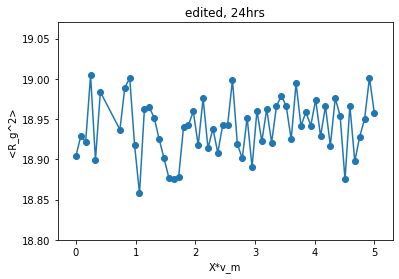

In [10]:
rg2 = []
for i, pair in enumerate(r_df_list):
    df = pair[1]
    poly_net = PolymerNetwork(df.X.values, df.Y.values, df.Z.values, df.Type.values, beads_per_polymer=40)   
    rg2.append(poly_net.find_rg2())
    
chi_vals = np.array(chi_val_list)
chi_v_m = chi_vals/0.2
plt.plot(chi_v_m, rg2)
plt.scatter(chi_v_m, rg2)
plt.ylabel("<R_g^2>")
plt.xlabel("X*v_m")
plt.title("edited, 24hrs")
plt.ylim((18.8, 19.07))
#avg over 2000 polymers in each replica